<a href="https://colab.research.google.com/github/kimdesok/FinanceDataReader/blob/master/COVID_Stock_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid data and its relation to the stock price

##1. Setting libraries and environment
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing

In [1]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns


In [2]:
!pip install finance-datareader

#Ta-Lib library installation for calculating trend indicators

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib
import datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3617    0  3617    0     0   9394      0 --:--:-- --:--:-- --:--:--  9394
100  503k  100  503k    0     0   470k      0  0:00:01  0:00:01 --:--:-- 1845k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3685    0  3685    0     0  19192      0 --:--:-- --:--:-- --:--:-- 19192
100  406k  100  406k    0     0   448k      0 --:--:-- --:--:-- --:--:-- 1442k



### Downloading the COVID data

In [3]:
!wget https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv

--2022-02-01 20:14:26--  https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv [following]
--2022-02-01 20:14:26--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45054712 (43M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  42.97M   115MB/s    in 0.4s    

2022-02-01 20:14:28 (115 MB/s) - ‘owid-covid-data.csv’ saved [4505

##2. Brief EDA
 > * Display the correlation between the price and the COVID  new cases in a nation.

In [34]:
import FinanceDataReader as fdr
from datetime import date
from numpy.core.numeric import ComplexWarning

# Plot the new COVID case
def new_case_graph(my_file, inputLocation, inputPastDays):
  short_df = pd.read_csv(my_file)
  #print(short_df.columns)

  short_df = short_df[short_df['location']==inputLocation]

  columns=['date', 'new_cases']
  short_df= short_df[columns]

  # sort the short sell data
  short_df['Date'] = pd.to_datetime(short_df['date'])
  short_df = short_df.pivot_table(index='Date', values=['new_cases'])
  #short_df = short_df.sort_index()

  #Set the beginning date for the analysis
  #print(short_df.index[0])
  start_date = short_df.index[0]
  end_date = short_df.index[-1] 

  #end_date = date.today()

  print('Displaying the data from ', short_df.index[-1*inputPastDays], 'to ', end_date, '\n')

  plt.figure(figsize = (10,8))

  plt.plot(short_df['new_cases'][-1*inputPastDays:], color = 'lime', label='New cases', marker='o', alpha=0.5)
  plt.plot(short_df['new_cases'][-1*inputPastDays:].ewm(7, min_periods=1).mean(), color = 'green', label='New cases 7 day ewma')
  plt.xlabel('Date')
  plt.ylabel('New cases')
  plt.title('COVID new cases in ' + inputLocation)
  plt.legend()
  plt.grid(True)
  plt.show() 

  print(short_df.tail())
  return short_df

In [36]:
# get stock codes from the company names
def stock_graphs(Company_names, short_df):

    #Set the beginning date for the analysis
    start_date = short_df.index[0]
    #end_date = short_df.index[-1] 
    end_date = date.today()
    print('Displaying the data from ', start_date, 'to ', end_date, '\n')

    for name, code in Company_names.items():
      # Load the stock market data from start_date to today
      full_df = fdr.DataReader(code, start_date, end_date)

      #Data transform using the closing price
      full_df = full_df.pivot_table(index='Date', values=['Close'])

      full_df.columns = [name]

      #stock_data.info()

      full_df['mva5'] = full_df[name].fillna(0).ewm(50, min_periods=1).mean()
      full_df['mva5_cases'] = short_df['new_cases'].fillna(0).ewm(7, min_periods=1).mean()

      plt.figure(figsize = (10,8))
      norm_df = full_df[name]/full_df[name].max()
      plt.plot(norm_df, color = 'lime', label ='Price', alpha=0.5)
      plt.plot(norm_df.fillna(0).ewm(50, min_periods=1).mean(), color = 'green', label='Price 50 days ewma')

      case_norm_df = short_df['new_cases']/short_df['new_cases'].max()
      plt.plot(case_norm_df, color = 'darkorange', label='New cases', alpha=0.5)
      plt.plot(case_norm_df.fillna(0).ewm(7, min_periods=1).mean(), color = 'orange', label='New cases 7 days ewma')

      plt.xlabel('Date')
      plt.xticks(rotation=45)
      plt.ylabel('Fractional Change')
      plt.title(name +': Relation between the price and COVID new cases')
      plt.legend()
      plt.grid(True)

      plt.show()  # show the plot

      plt.clf()  # clear the plot space

def get_codes(my_file, names):
  try:
    with open(my_file, 'r') as f:
      code_df = pd.read_csv(f)
      #print(type(code_df))
  except:
    print("Make sure to mount the drive!")

  #print(code_df.head())

  code_list = {}
  for eng, kor in names.items():
    code = code_df.query("names=='{}'".format(kor))['codes'].to_string(index=False)
    code = code.strip()
    code_list[code] = code
  return code_list

Displaying the data from  2021-12-13 00:00:00 to  2022-01-31 00:00:00 



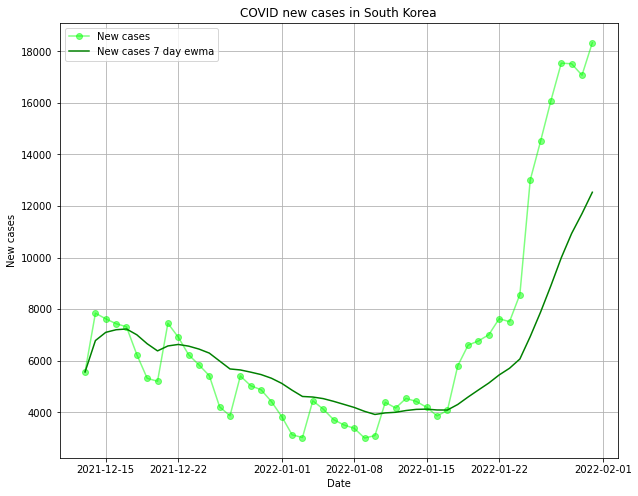

            new_cases
Date                 
2022-01-27    16085.0
2022-01-28    17540.0
2022-01-29    17515.0
2022-01-30    17072.0
2022-01-31    18333.0
Displaying the data from  2020-01-23 00:00:00 to  2022-02-01 



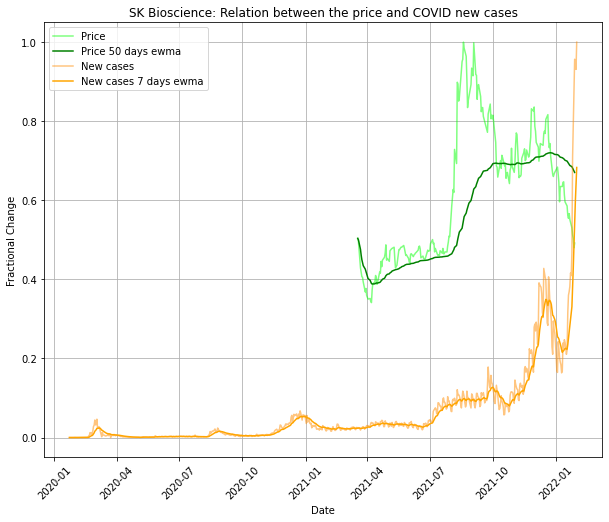

<Figure size 432x288 with 0 Axes>

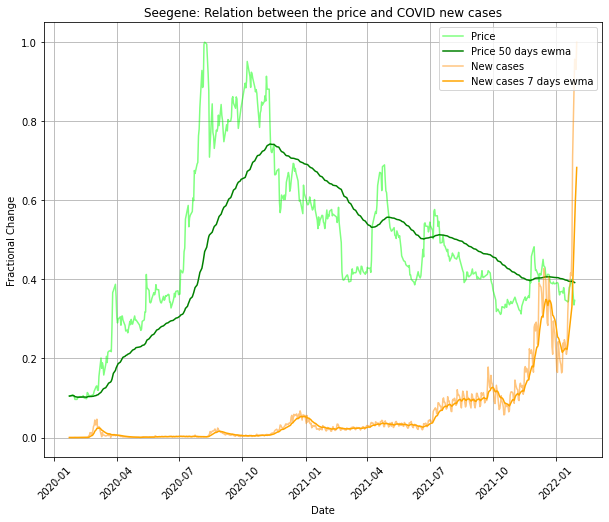

<Figure size 432x288 with 0 Axes>

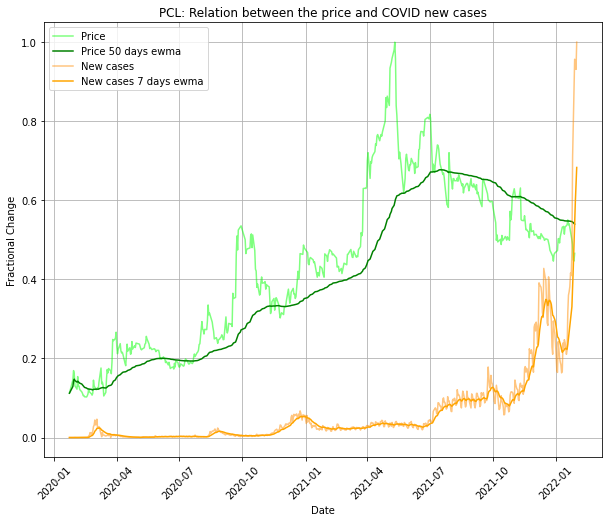

<Figure size 432x288 with 0 Axes>

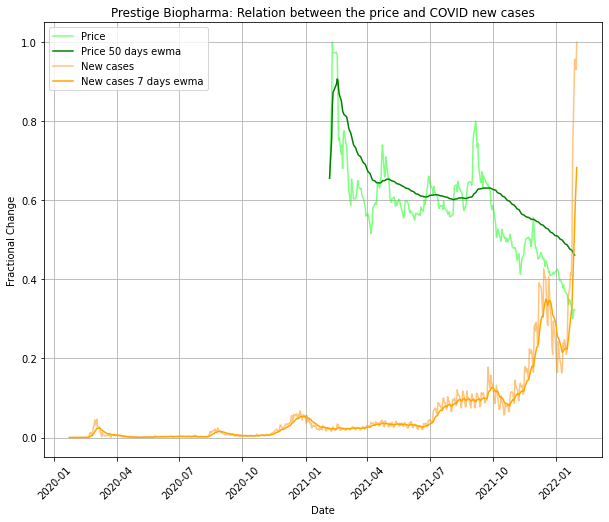

<Figure size 432x288 with 0 Axes>

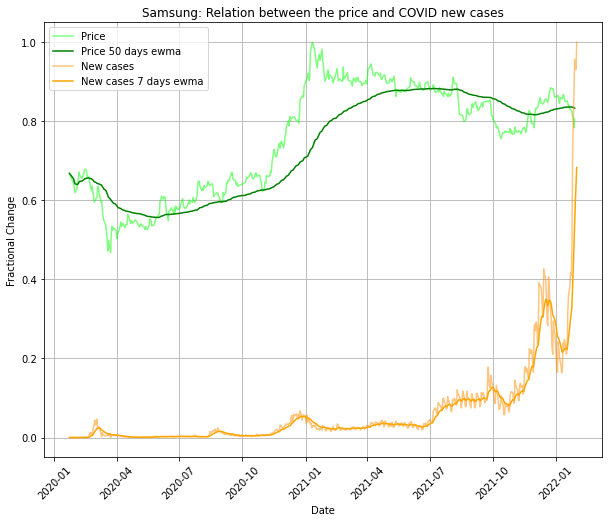

<Figure size 432x288 with 0 Axes>

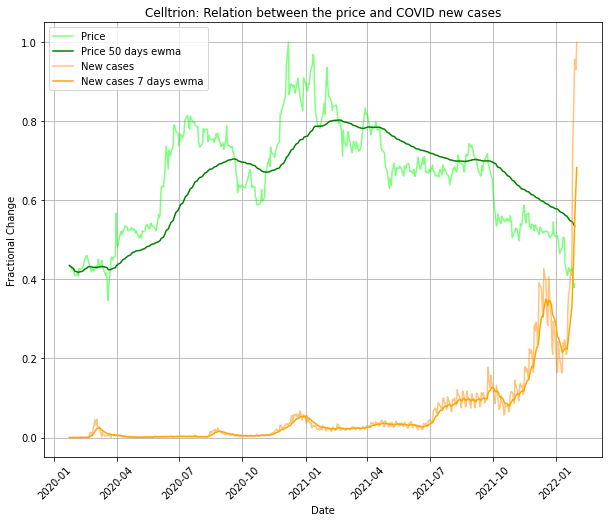

<Figure size 432x288 with 0 Axes>

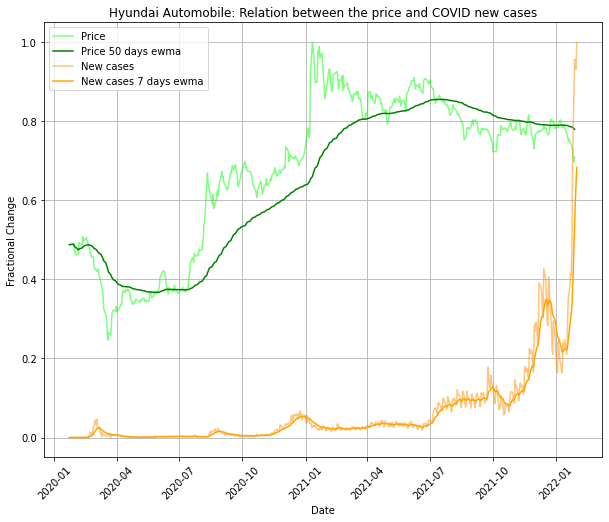

<Figure size 432x288 with 0 Axes>

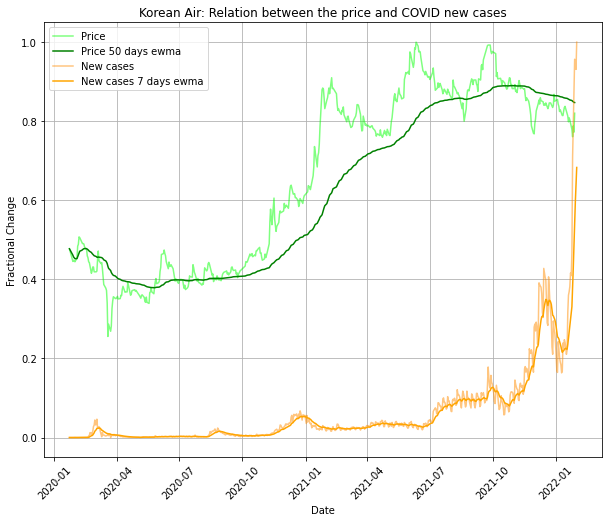

<Figure size 432x288 with 0 Axes>

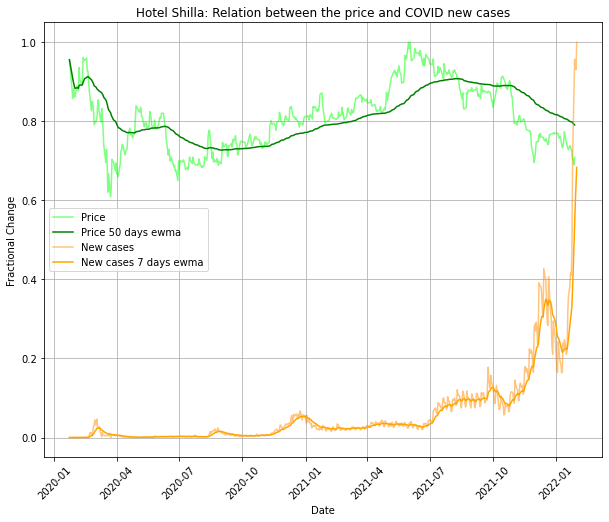

<Figure size 432x288 with 0 Axes>

In [37]:
#This dictionary contains the name of a company in English and in Korean.
Company_names = {'SK Bioscience':'SK바이오사이언스', 'Seegene':'씨젠','PCL':'피씨엘', \
                  'Prestige Biopharma':'프레스티지바이오파마',\
                  'Samsung':'삼성전자','Celltrion':'셀트리온', 'Hyundai Automobile':'현대차', \
                  'Korean Air':'대한항공', 'Hotel Shilla':'호텔신라'}

#The stock data of s. Korea requires a numeric code for the retrieval.
#The stock_codes.csv has the name of the stock in Korean and its numeric code.
my_codes = '/content/drive/MyDrive/datasets/stock_codes.csv'

#To get the list of numeric codes
code_list = get_codes(my_codes, Company_names)
#print(code_list)

# Load the covid data from the OWID site
my_file = '/content/owid-covid-data.csv'
inputLocation = 'South Korea'
inputPastDays = 50

# Plot the covid data
short_df = new_case_graph(my_file, inputLocation, inputPastDays)

# Get the company name in English as keys and the numeric code as values (in the dictionary)
Company_names = {keys: list(code_list)[i] for i, keys in enumerate(Company_names.keys())}
#print(Company_names)

# Plot the stock and COVID data
stock_graphs(Company_names, short_df)

Displaying the data from  2021-10-24 00:00:00 to  2022-01-31 00:00:00 



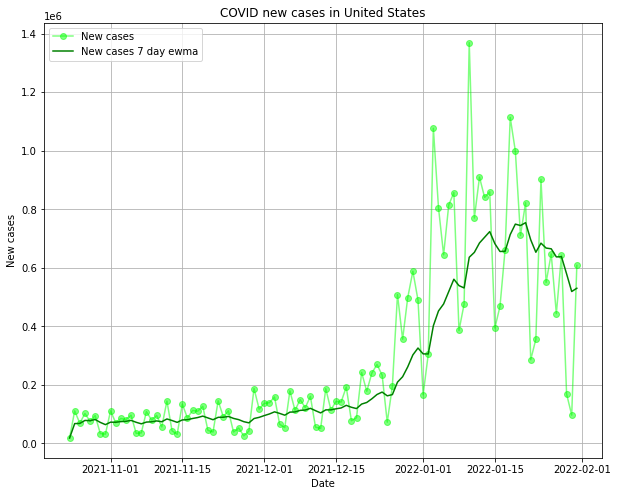

            new_cases
Date                 
2022-01-27   443607.0
2022-01-28   642857.0
2022-01-29   169002.0
2022-01-30    96887.0
2022-01-31   608201.0
{'Bio-Rad Laboratories, Inc.': 'BIO', 'Novavax, Inc.': 'NVAX', 'Abbott Laboratories': 'ABT', 'Quidel Corporation': 'QDEL', 'Moderna, Inc.': 'MRNA', 'Pfizer Inc. ': 'PFE'}
Displaying the data from  2020-01-23 00:00:00 to  2022-02-01 



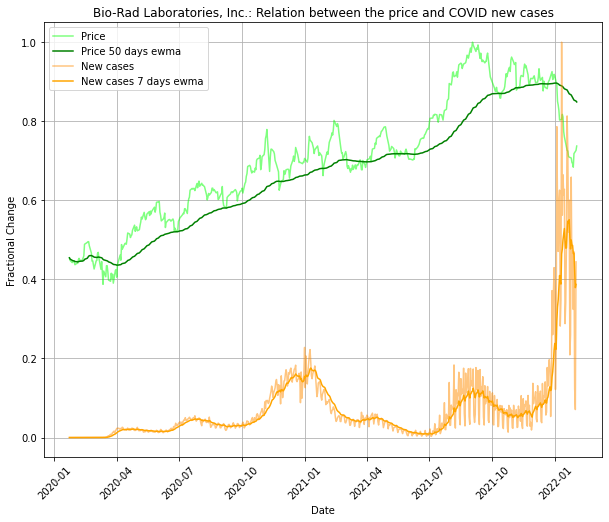

<Figure size 432x288 with 0 Axes>

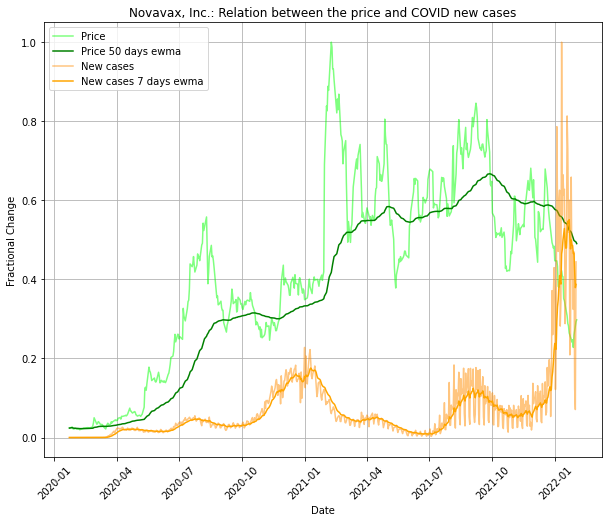

<Figure size 432x288 with 0 Axes>

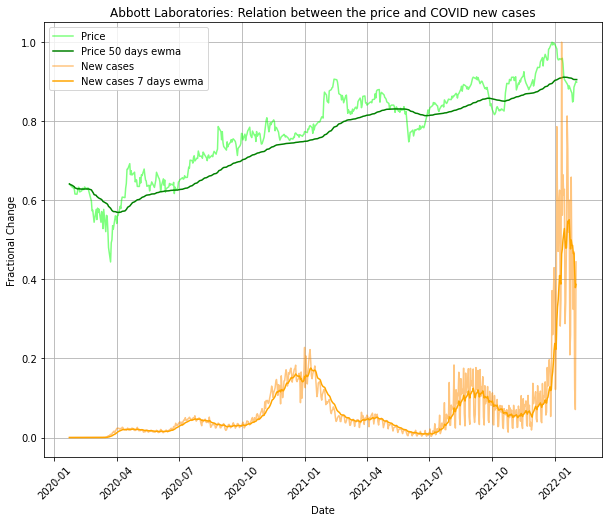

<Figure size 432x288 with 0 Axes>

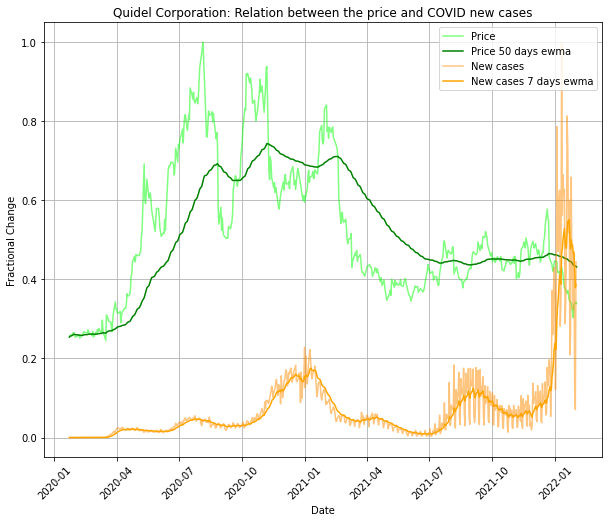

<Figure size 432x288 with 0 Axes>

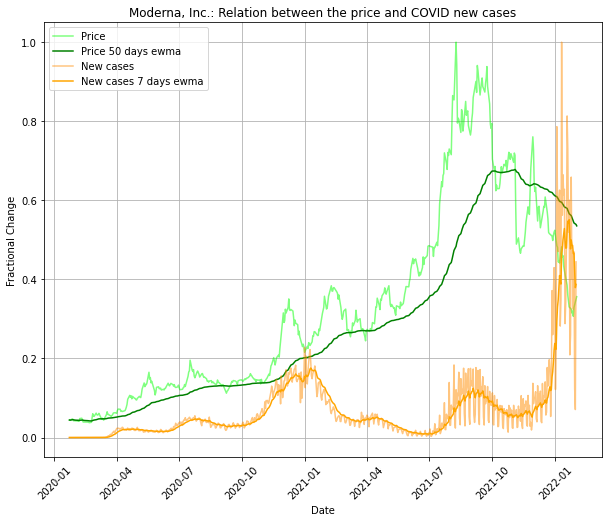

<Figure size 432x288 with 0 Axes>

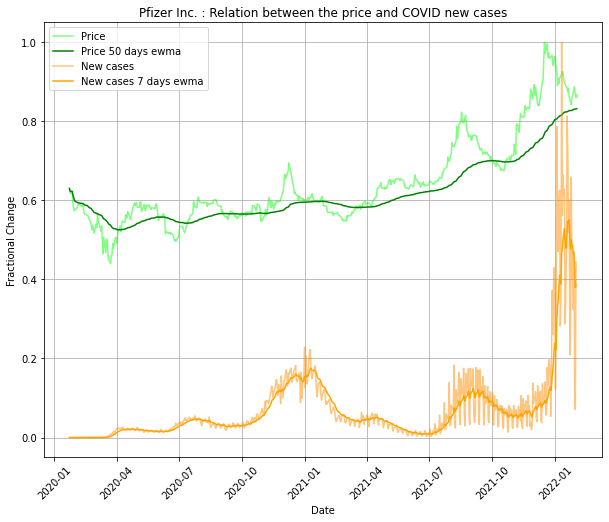

<Figure size 432x288 with 0 Axes>

In [38]:
#code_list is NOT required for US stocks.
inputLocation = 'United States'
inputPastDays = 100 
short_df = new_case_graph(my_file, inputLocation, inputPastDays)

#For US Companies
US_Companies= {'Bio-Rad Laboratories, Inc.':'BIO', 'Novavax, Inc.':'NVAX', 'Abbott Laboratories':'ABT', 'Quidel Corporation':'QDEL', \
               'Moderna, Inc.' : 'MRNA', 'Pfizer Inc. ':'PFE'}

print(US_Companies)
stock_graphs(US_Companies, short_df)

{'WisdomTree US EFF Core Fund': 'NTSX', 'Amplify BlackSwan Growth & Treasury Core': 'SWAN', 'iShares Core Growth Allocation': 'AOR', 'RPAR Risk Parity': 'RPAR', 'iShares TIPS Bond ETF': 'TIP'}
Displaying the data from  2020-01-23 00:00:00 to  2022-02-01 



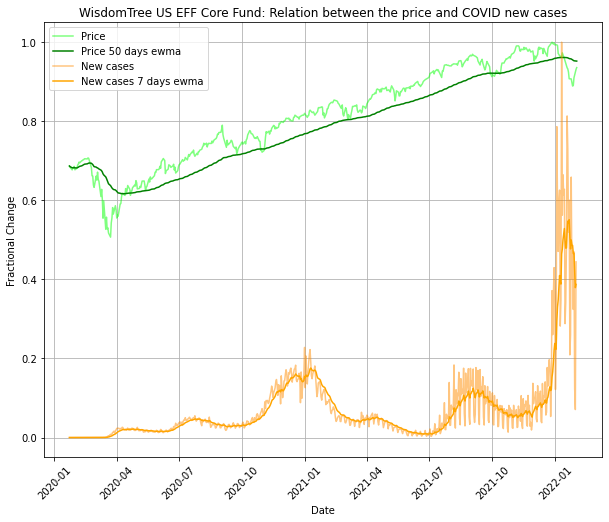

<Figure size 432x288 with 0 Axes>

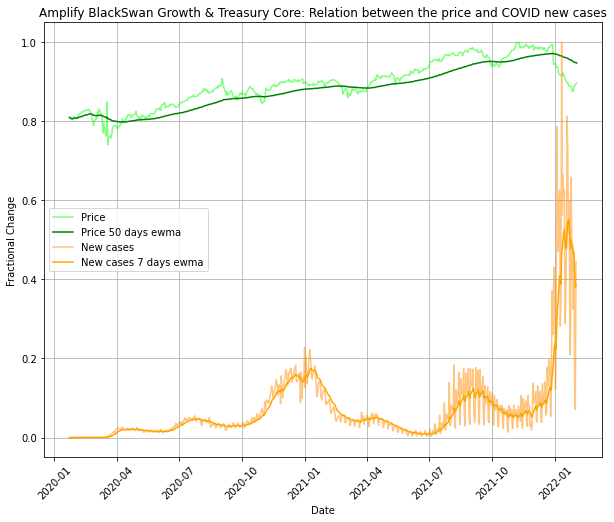

<Figure size 432x288 with 0 Axes>

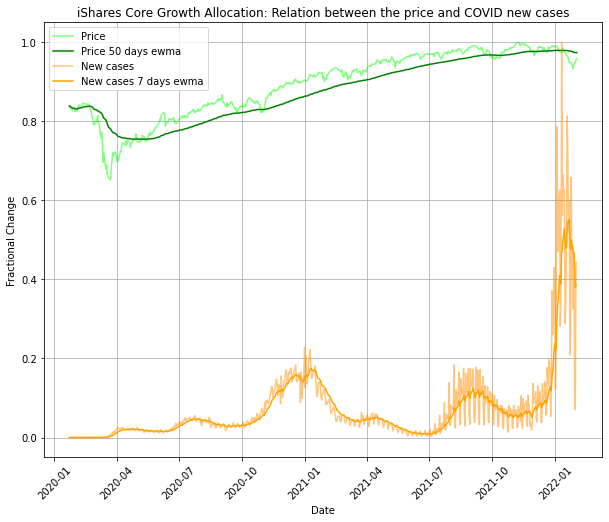

<Figure size 432x288 with 0 Axes>

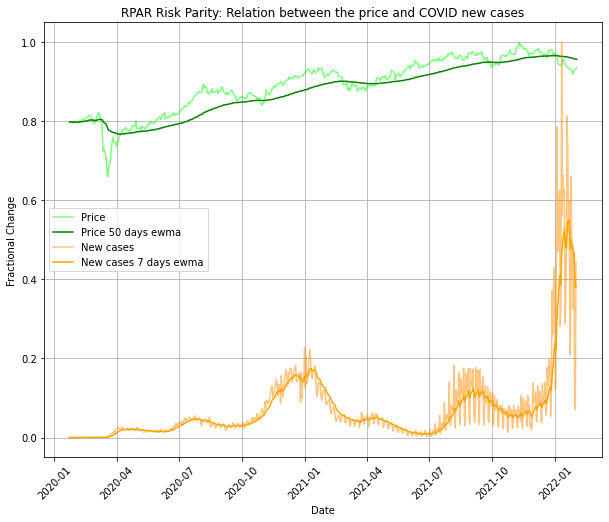

<Figure size 432x288 with 0 Axes>

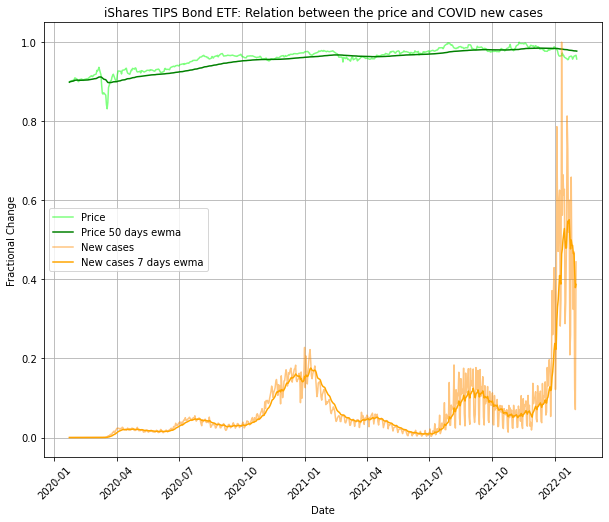

<Figure size 432x288 with 0 Axes>

In [39]:
#For US EFTs
US_ETFs = {'WisdomTree US EFF Core Fund':'NTSX','Amplify BlackSwan Growth & Treasury Core':'SWAN', \
               'iShares Core Growth Allocation':'AOR', 'RPAR Risk Parity': 'RPAR', 'iShares TIPS Bond ETF':'TIP'}

print(US_ETFs)
stock_graphs(US_ETFs, short_df)